In [1]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import SVHN
import torchvision
from torchvision import transforms
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import os
from tqdm.auto import tqdm

root_path = '../'
import sys
sys.path.insert(-1, root_path)

from src.data import get_transforms
from src.utils import composed_model, compute_likelihood
%matplotlib inline

In [2]:
device = "cuda:0"

In [3]:
transforms_svhn_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4376821 , 0.4437697 , 0.47280442],
                         std=[0.19803012, 0.20101562, 0.19703614])])



transforms_svhn_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4376821 , 0.4437697 , 0.47280442],
                         std=[0.19803012, 0.20101562, 0.19703614])
])

In [4]:
dataset_train = SVHN(os.path.join(root_path, 'data/svhn'), split="train", download=True,
                                 transform=transforms_svhn_train)
dataset_test = SVHN(os.path.join(root_path, 'data/svhn'), split="test", download=True,
                    transform=transforms_svhn_test
                   )

Using downloaded and verified file: ../data/svhn/train_32x32.mat
Using downloaded and verified file: ../data/svhn/test_32x32.mat


In [5]:
with open(os.path.join(root_path, 'experiment_logs/184/final_dict.pickle'), 'rb') as file: # 184, 166
    loaded_data = pickle.load(file)

In [6]:
personal_models = loaded_data['personal_models']
shared_model = loaded_data['shared_model']
prior_models = loaded_data['prior_models']
train_loaders = loaded_data['train_loaders']
test_loaders = loaded_data['test_loaders']

In [7]:
len(test_loaders[0].dataset.idxs)

100

In [8]:
svhn_dataloader = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=100)

In [9]:
LOG_LIKELIHOOD_FN = lambda x, y: -nn.CrossEntropyLoss(reduction='sum')(x, y)

burn_in = 2
inner_iters = 5

In [10]:
def sample_personal_vec(personal_model, prior_model, shared_model, personal_train_loader, personal_optim):
    samples = torch.tensor([], device=device)
    for m in range(inner_iters):
        log_likelihood_term = compute_likelihood(personal_model=personal_model, dataloader=personal_train_loader,
                           log_likelihood_fn=LOG_LIKELIHOOD_FN, shared_model=shared_model,
                                                 composition_regime='composition', use_sgld=False)
        prior_negative_log_prob = prior_model.get_negative_log_prob(parameters_to_vector(personal_model.model.parameters()))


        personal_model_loss = prior_negative_log_prob - log_likelihood_term
        personal_model_loss.backward()

        personal_optim.step()
        personal_optim.zero_grad()

        if m >= burn_in:
            current_sample = parameters_to_vector(personal_model.model.parameters())[None].detach()
            samples = torch.cat([samples, current_sample])
        
    return samples

def marginal_prediction(samples, personal_model, shared_model, loader):
    with torch.no_grad():
        all_preds = []
        for sample in samples:
            p_preds = torch.tensor([], device=device)
            vector_to_parameters(
                    vec=sample,
                    parameters=personal_model.model.parameters()
                )
            model = composed_model(shared_model, personal_model, "composition")
            for batch in loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                p_pred = torch.softmax(model(x), dim=-1)
                p_preds = torch.cat([p_preds, p_pred])
            all_preds.append(p_preds[None])
    return all_preds

In [11]:
def entropy(p_preds):
    return np.sum(-p_preds * np.log(p_preds), axis=-1)            

In [12]:
def uncertainty_score(dataloader_ind, dataloader_ood, personal_train_loader, personal_model, prior_model, shared_model):
    selected_classes = []
    for batch in personal_train_loader:
        _, y = batch
        selected_classes.append(y.cpu().numpy())
    selected_classes = np.unique(np.vstack(selected_classes))
    for p in personal_model.parameters():
        p.requires_grad_(True)
    scores = [[], []]
    all_p_preds = [[], []]
    loaders = [dataloader_ind, dataloader_ood]
    personal_optim = torch.optim.Adam(personal_model.parameters(), lr=3e-2)
    samples = sample_personal_vec(personal_model=personal_model, prior_model=prior_model, shared_model=shared_model,
                             personal_train_loader=personal_train_loader, personal_optim=personal_optim)
    for p in personal_model.parameters():
        p.requires_grad_(False)
        
    for i in range(len(loaders)):
        all_preds = marginal_prediction(
            samples=samples,
            personal_model=personal_model,
            shared_model=shared_model,
            loader=loaders[i],
        )
        
        concat = torch.cat(all_preds, dim=0)[:, :, selected_classes]
        
        p_preds = torch.mean(concat, dim=0).cpu().numpy()
        he = entropy(p_preds)
        sc = entropy(concat.cpu().numpy())
        eh = np.mean(sc, 0)
        
        res = {
            "EH": eh,
            "HE": he,
            "BALD": he - eh
        }
        
        scores[i].append(res)
        # scores[i].append(he)
        
        concat = torch.cat(all_preds, dim=0)
        p_preds = torch.mean(concat, dim=0).cpu().numpy()
        all_p_preds[i].append(p_preds)
        
    ind_d_scores = {}
    out_d_scores = {}

    for k in ["EH", "HE", "BALD"]:
        ind_d_scores[k] = np.hstack([el[k] for el in scores[0]])
    for k in ["EH", "HE", "BALD"]:
        out_d_scores[k] = np.hstack([el[k] for el in scores[1]])
    
    ind_d_probs = np.hstack(all_p_preds[0])
    out_d_probs = np.hstack(all_p_preds[1])
    
    return ind_d_scores, out_d_scores, ind_d_probs, out_d_probs

In [13]:
def get_uncertainty_scores(shared_model, prior_models, personal_models, train_loaders, test_loaders, ood_loader, n_models):
    model_scores = []
    if n_models == -1:
        n_models = len(personal_models)
    for i in tqdm(range(n_models)):
        ind_d = test_loaders[i]
        ood_d = ood_loader
        train_d = train_loaders[i]
        model_scores.append(
            uncertainty_score(
                dataloader_ind=ind_d,
                dataloader_ood=ood_d,
                personal_train_loader=train_d,
                personal_model=personal_models[i],
                prior_model=prior_models[0],
                shared_model=shared_model
            )
                           )
    return model_scores

In [15]:
scores = get_uncertainty_scores(
    shared_model=shared_model,
    prior_models=prior_models,
    personal_models=personal_models,
    train_loaders=train_loaders,
    test_loaders=test_loaders,
    ood_loader=svhn_dataloader,
    n_models=15,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
from src.utils import pretty_matplotlib_config
pretty_matplotlib_config(17)

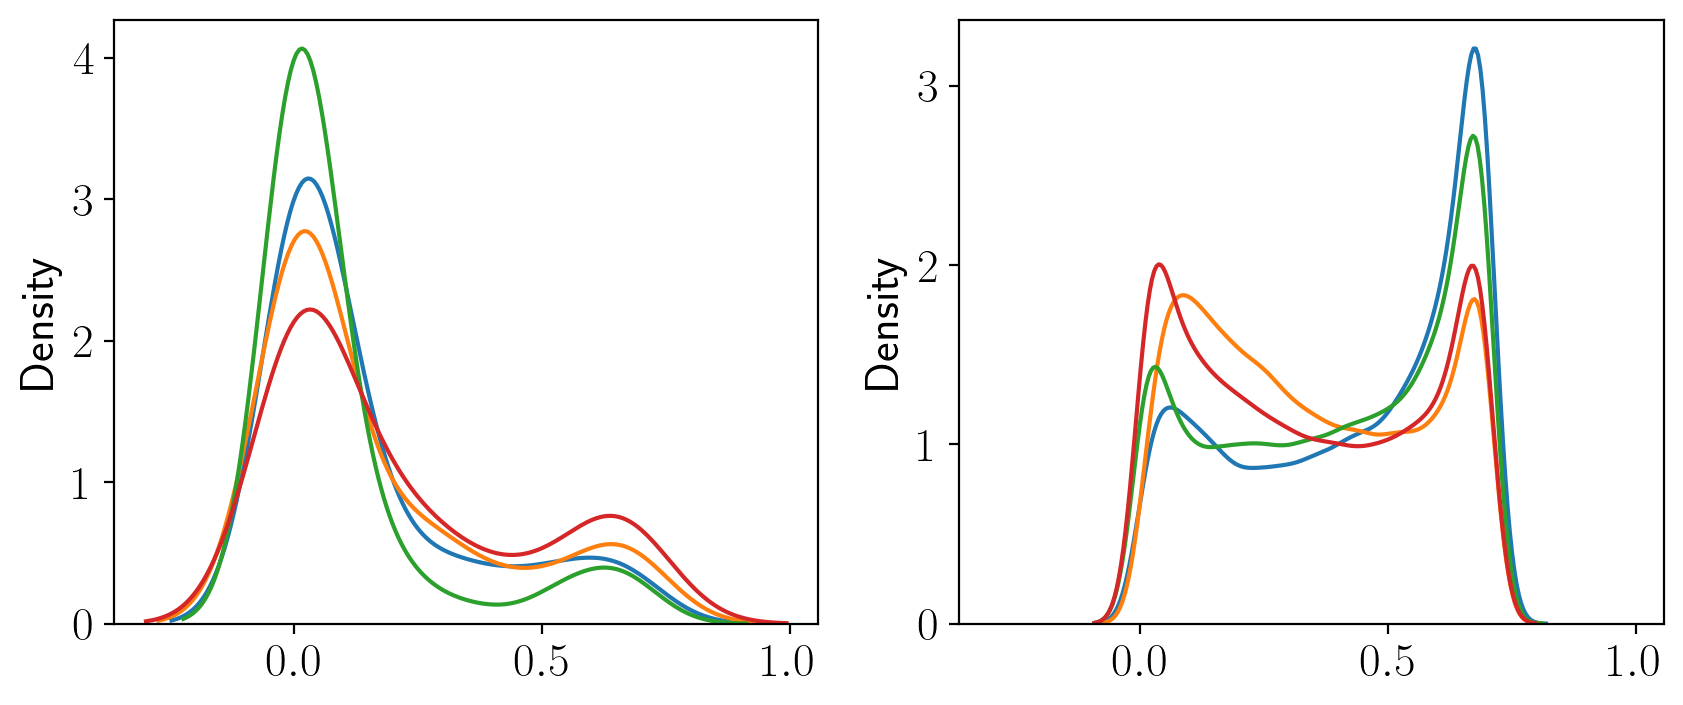

In [22]:
unc_type = "HE"  # "EH", "HE", "BALD"

fig, ax = plt.subplots(ncols=2, dpi=200, figsize=(10, 4), sharex=True)



for i in [0, 10, 9, 7]:#len(scores)):
    ind, ood = scores[i][:2]
    
    # ax[0].set_xlim(1e-6)
    # ax[0].set_xscale("log")
    # ax[1].set_xscale("log")
    # ax[1].set_xlim(1e-6)
    
    sns.kdeplot(ind[unc_type], ax=ax[0], label="InD")
    sns.kdeplot(ood[unc_type], ax=ax[1], label="OoD")

# plt.legend()
# plt.savefig("./cifar10_2_models_uncertainty.pdf", format="pdf")
plt.show();

In [23]:
# trained classes vs untrained

In [24]:
ind_mean_scores = np.vstack([scores[i][0][unc_type][:90][None] for i in range(len(scores))]).mean(0)
ood_mean_scores = np.vstack([scores[i][1][unc_type][None] for i in range(len(scores))]).mean(0)

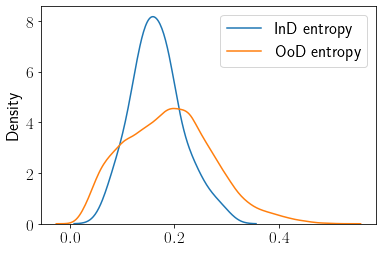

In [25]:
plt.figure()

sns.kdeplot(ind_mean_scores, label="InD entropy")
sns.kdeplot(ood_mean_scores, label="OoD entropy")

plt.legend()
plt.show();

In [26]:
from alpaca.utils.datasets.builder import build_dataset
import alpaca.calibrator as calibrator

In [27]:
# Let's build helper function to calculate all the calibration errors
def compute_errors(n_bins, probs, labels, len_dataset, threshold):
    ece = calibrator.compute_ece(n_bins, probs, labels, len_dataset)
    sce = calibrator.compute_sce(n_bins, probs, labels)
    # ace = calibrator.compute_ace(n_bins, probs, labels)
    # tace = calibrator.compute_tace(threshold, probs, labels, n_bins)
    errors = {
        'ece' : ece,
        'sce' : sce,
        # 'ace' : ace,
        # 'tace' : tace
    }
    for name, calibration_error in errors.items():
        print(name, ' = ', calibration_error)

In [54]:
model_index = 2

In [55]:
probs = scores[model_index][2]

In [56]:
probs_ood = scores[model_index][3]

<AxesSubplot:ylabel='Density'>

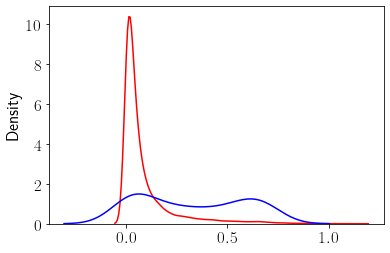

In [57]:
sns.kdeplot(entropy(probs_ood), color='red')
sns.kdeplot(entropy(probs), color='blue')

In [58]:
y_true = []
for batch in test_loaders[model_index]:
    _, y = batch
    y_true.append(y)

In [60]:
val_labels = y_true[0].reshape(-1).cpu().numpy()

In [62]:
compute_errors(n_bins=2, probs=probs, labels=val_labels.reshape(-1, 1),
               len_dataset=np.shape(probs)[0], threshold=0.9)

ece  =  tensor([0.0697])
sce  =  tensor([0.0108])


In [63]:
sys.path.insert(0, '../federated_learning/')

In [64]:
from reliability_diagrams.reliability_diagrams import reliability_diagram
from src.utils import pretty_matplotlib_config

In [65]:
pretty_matplotlib_config(17)

In [1]:
## UNCOMMENT THIS TO PLOT RELIABILITY DIAG!
# fig = reliability_diagram(
#     true_labels=y_true[0].cpu().numpy().reshape(-1),
#     pred_labels=np.argmax(probs, axis=-1),
#     confidences=np.max(probs, axis=-1),
#     num_bins=10,
#     dpi=200,
#     figsize=(7, 5),
#     return_fig=True
# )
# fig.savefig(f"../pics/reliability_diag_cifar10_2cl_{model_index}.pdf", format='pdf')
# plt.show();

In [117]:
np.mean(np.argmax(probs, axis=-1) == y_true[0].cpu().numpy().reshape(-1))

0.94